# Лабораторная работа №10

In [1]:
from itertools import chain, islice, repeat
from typing import Callable, Generator, Iterable, NamedTuple

import numpy as np
from matplotlib import pyplot as plt
from more_itertools import windowed
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


RANDOM_STATE = 42
MAX_DEPTH = 5

### Разделение выборки на обучающую и контрольную

In [2]:
BOSTON_DATA = load_boston()

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    BOSTON_DATA.data, BOSTON_DATA.target, train_size=0.75, random_state=RANDOM_STATE
)

### Обучение деревьев решений

In [3]:
DECISION_TREE_COUNT = 50
DEVIATION_COEFFICIENT = 0.9


class TreePredictor(NamedTuple):
    tree: DecisionTreeRegressor
    coefficient: float = DEVIATION_COEFFICIENT
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.tree.predict(x) * self.coefficient


def train_trees(
    x: np.ndarray, 
    y: np.ndarray, 
    deviation_coeff: Iterable[float] = (),
    decision_tree_count: int = 50,
    max_depth: int = MAX_DEPTH,
    random_state=RANDOM_STATE,
) -> Callable[[np.ndarray], np.ndarray]:
    deviation_coeff = chain(deviation_coeff, repeat(DEVIATION_COEFFICIENT))
    predictors = [
        TreePredictor(
            DecisionTreeRegressor(max_depth=max_depth, random_state=random_state),
            coeff
        )
        for coeff in islice(deviation_coeff, decision_tree_count)
    ]
    predictors[0].tree.fit(x, y)
    y_train_dev = y.copy()
    for prev_pred, current_pred in windowed(predictors, 2):
        y_train_dev -= prev_pred.predict(X_TRAIN)
        current_pred.tree.fit(x, y_train_dev)
    return lambda x: sum(p.predict(x) for p in predictors)

### Постоянные коэффициенты весов

In [4]:
const_coeff_predictor = train_trees(X_TRAIN, Y_TRAIN)
mse_const_coeff = mean_squared_error(Y_TEST, const_coeff_predictor(X_TEST))
print(f"Mean squared error = {mse_const_coeff}")

Mean squared error = 13.600735758368467


### Уменьшение коэффициентов весов

In [5]:
def deviation_coeff_gen(*args) -> Generator[float, None, None]:
    for i in range(*args):
        yield DEVIATION_COEFFICIENT / (1 + i)

variable_coeff_predictor = train_trees(X_TRAIN, Y_TRAIN, deviation_coeff_gen(DECISION_TREE_COUNT))
mse_var_coeff = mean_squared_error(Y_TEST, variable_coeff_predictor(X_TEST))
print(f"Mean squared error = {mse_var_coeff}")

Mean squared error = 8.987354822947314


### Оценка влияния количества итераций на переобучение бустинга

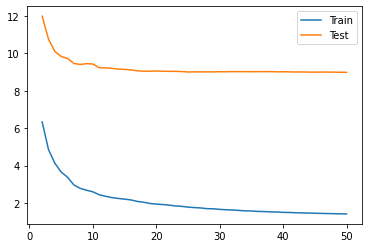

In [6]:
mses_train_tree_count = []
mses_test_tree_count = []
it_counter = range(2, DECISION_TREE_COUNT + 1)
for i in it_counter:
    predictor = train_trees(X_TRAIN, Y_TRAIN, deviation_coeff_gen(DECISION_TREE_COUNT), decision_tree_count=i)
    mses_train_tree_count.append(mean_squared_error(Y_TRAIN, predictor(X_TRAIN)))
    mses_test_tree_count.append(mean_squared_error(Y_TEST, predictor(X_TEST)))

plt.plot(it_counter, mses_train_tree_count, label="Train")
plt.plot(it_counter, mses_test_tree_count, label="Test")
plt.legend()
plt.show()

### Оценка влияния глубины деревьев на переобучение бустинга

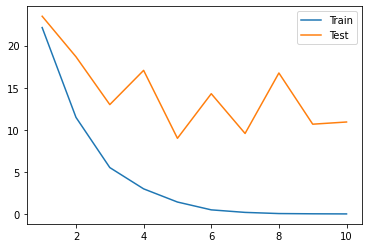

In [7]:
mses_train_tree_depth = []
mses_test_tree_depth = []
depth_counter = range(1, 11)
for i in depth_counter:
    predictor = train_trees(X_TRAIN, Y_TRAIN, deviation_coeff_gen(DECISION_TREE_COUNT), max_depth=i)
    mses_train_tree_depth.append(mean_squared_error(Y_TRAIN, predictor(X_TRAIN)))
    mses_test_tree_depth.append(mean_squared_error(Y_TEST, predictor(X_TEST)))

plt.plot(depth_counter, mses_train_tree_depth, label="Train")
plt.plot(depth_counter, mses_test_tree_depth, label="Test")
plt.legend()
plt.show()

### Оценка работы алгоритма линейной регрессии

In [8]:
lin_reg = LinearRegression(normalize=True, n_jobs=-1).fit(X_TRAIN, Y_TRAIN)
mse_lin_reg = mean_squared_error(Y_TEST, lin_reg.predict(X_TEST))
print(f"Mean squared error = {mse_lin_reg}")
print(f"{'Boosting' if mse_var_coeff < mse_lin_reg else 'Linear regression'} wins!")

Mean squared error = 22.09869482709799
Boosting wins!
